# Modeling Notebook 

## Imports & setup

In [ ]:
import pathlib, json, warnings, joblib, optuna, inspect
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor

try:
    from lightgbm import LGBMRegressor
    has_lgbm = True
except ImportError:
    has_lgbm = False
try:
    from catboost import CatBoostRegressor
    has_cat = True
except ImportError:
    has_cat = False
try:
    import shap
    shap.initjs(); has_shap = True
except ImportError:
    has_shap = False


## Load dataset

In [2]:
import sys
from pathlib import Path

project_root = Path.cwd()
if (project_root / "predicting-cyclodextrin-bioavailability").is_dir():
    project_root = project_root / "predicting-cyclodextrin-bioavailability"

sys.path.append(str(project_root))

from scripts.utils import env_variables as env

DATA_DIR = Path(env.CLEAN_DATA_DIR)
USE_ISO2VEC = False
file = DATA_DIR / ("dataset_with_vec.parquet" if USE_ISO2VEC else "dataset_without_vec.parquet")
df = pd.read_parquet(file)
X = df.drop(columns="DeltaG"); y = df["DeltaG"]
print(df.shape)



(980, 9)


## Train/test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Helper metrics

In [4]:
def _rmse(y_true, y_pred):
    try:
        from sklearn.metrics import root_mean_squared_error
        return root_mean_squared_error(y_true, y_pred)
    except ImportError:
        if 'squared' in inspect.signature(mean_squared_error).parameters:
            return mean_squared_error(y_true, y_pred, squared=False)
        return np.sqrt(mean_squared_error(y_true, y_pred))
def eval_reg(y_true, y_pred):
    return {'MAE': mean_absolute_error(y_true, y_pred),
            'RMSE': _rmse(y_true, y_pred),
            'R2': r2_score(y_true, y_pred)}
results = {}


## Baseline models

In [5]:
ridge = Pipeline([('scaler', StandardScaler()), ('model', Ridge())]).fit(X_train, y_train)
results['Ridge'] = eval_reg(y_test, ridge.predict(X_test))

rf = Pipeline([('scaler', StandardScaler()),
               ('model', RandomForestRegressor(n_estimators=600, n_jobs=-1, random_state=42))]).fit(X_train, y_train)
results['RandomForest'] = eval_reg(y_test, rf.predict(X_test))

xgb_base = XGBRegressor(n_estimators=800, learning_rate=0.05, max_depth=8,
                        subsample=.8, colsample_bytree=.8, random_state=42,
                        n_jobs=-1, objective='reg:squarederror')
xgb_base.fit(X_train, y_train)
results['XGB_baseline'] = eval_reg(y_test, xgb_base.predict(X_test))

print(results)


{'Ridge': {'MAE': 3.0930119232155238, 'RMSE': 3.8673426858532762, 'R2': 0.29652148129925093}, 'RandomForest': {'MAE': 1.9907875970805047, 'RMSE': 2.6788934340357033, 'R2': 0.6624513288302344}, 'XGB_baseline': {'MAE': 2.0900187223784776, 'RMSE': 2.8938352742589215, 'R2': 0.6061116468667798}}


## Optuna‑pruned XGBoost with manual K‑Fold

In [6]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 600, 1600, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'max_leaves': trial.suggest_int('max_leaves', 0, 128),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
    }
    model = XGBRegressor(**params, objective='reg:squarederror', eval_metric='rmse', n_jobs=-1,
                         random_state=42, tree_method='hist')

    cv = KFold(5, shuffle=True, random_state=42)
    rmses = []
    for fold, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr,
                  eval_set=[(X_val, y_val)],
                  verbose=False,
                  # callbacks=[XGBoostPruningCallback(trial, 'validation_0-rmse')]
                )

        rmses.append(_rmse(y_val, model.predict(X_val)))
    return np.mean(rmses)

study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective_xgb, n_trials=100, timeout=2*60*60)
best_xgb = XGBRegressor(**study.best_params, objective='reg:squarederror', eval_metric='rmse',
                        n_jobs=-1, random_state=42, tree_method='hist')
best_xgb.fit(X_train, y_train)
results['XGB_tuned'] = eval_reg(y_test, best_xgb.predict(X_test))
print('Best XGB', results['XGB_tuned'])


[I 2025-04-25 12:37:23,627] A new study created in memory with name: no-name-87cdad2d-5603-4009-8158-45acb43a5761
[I 2025-04-25 12:37:26,911] Trial 0 finished with value: 3.335622253159446 and parameters: {'n_estimators': 1600, 'learning_rate': 0.008930636721792978, 'max_depth': 6, 'min_child_weight': 20, 'subsample': 0.5643047178666626, 'colsample_bytree': 0.6440098158816854, 'gamma': 1.7910984346492775, 'reg_alpha': 4.699199815161106, 'reg_lambda': 2.406144279208987, 'max_leaves': 86, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 3.335622253159446.
[I 2025-04-25 12:37:29,814] Trial 1 finished with value: 4.39521766782385 and parameters: {'n_estimators': 900, 'learning_rate': 0.0001674493500632213, 'max_depth': 8, 'min_child_weight': 11, 'subsample': 0.6159478087430965, 'colsample_bytree': 0.42996795723606074, 'gamma': 0.4952207552783894, 'reg_alpha': 9.675403047821039, 'reg_lambda': 0.029967725314011817, 'max_leaves': 98, 'grow_policy': 'lossguide'}. Best is trial 0 with v

Best XGB {'MAE': 2.0526773744213336, 'RMSE': 2.7586974558693744, 'R2': 0.6420406788485293}


## HistGradientBoosting search

In [7]:
best_hgb, best_rmse = None, np.inf
for params in ParameterGrid({'learning_rate':[0.01,0.03,0.05],
                             'max_depth':[None,6,9],
                             'l2_regularization':[0.0,1.0],
                             'max_iter':[800,1200]}):
    model = HistGradientBoostingRegressor(random_state=42, **params).fit(X_train, y_train)
    rmse = _rmse(y_test, model.predict(X_test))
    if rmse < best_rmse:
        best_rmse, best_hgb, best_params_hgb = rmse, model, params
results['HGB'] = eval_reg(y_test, best_hgb.predict(X_test))
print('Best HGB', best_params_hgb, results['HGB'])


Best HGB {'l2_regularization': 0.0, 'learning_rate': 0.01, 'max_depth': None, 'max_iter': 800} {'MAE': 2.1716421302463176, 'RMSE': 2.8919735449791157, 'R2': 0.6066182946365397}


## LightGBM random search

In [8]:
if has_lgbm:
    best_lgb, best_rmse = None, np.inf
    space = {'n_estimators': np.arange(600,1501,200),
             'learning_rate': np.logspace(-3,-1,10),
             'num_leaves':[64,128,256,512],
             'max_depth':[-1,8,12],
             'subsample':[0.6,0.8,1.0],
             'colsample_bytree':[0.6,0.8,1.0]}
    for params in ParameterSampler(space, n_iter=40, random_state=42):
        model = LGBMRegressor(random_state=42, n_jobs=-1, **params).fit(X_train, y_train)
        rmse = _rmse(y_test, model.predict(X_test))
        if rmse < best_rmse:
            best_rmse, best_lgb, best_params_lgb = rmse, model, params
    results['LGBM'] = eval_reg(y_test, best_lgb.predict(X_test))
    print('Best LGBM', best_params_lgb, results['LGBM'])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 784, number of used features: 8
[LightGBM] [Info] Start training from score -15.046837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

## CatBoost quick run

In [9]:
if has_cat:
    cat = CatBoostRegressor(iterations=1500, learning_rate=0.03, depth=8,
                            loss_function='RMSE', random_seed=42, verbose=False).fit(X_train, y_train)
    results['CatBoost'] = eval_reg(y_test, cat.predict(X_test))
    print('CatBoost', results['CatBoost'])


CatBoost {'MAE': 2.0608673658969097, 'RMSE': 2.801255349294379, 'R2': 0.6309111506318541}


## Stacked ensemble

In [10]:
from sklearn.ensemble import StackingRegressor
stack = StackingRegressor(
    estimators=[('rf', rf['model']), ('xgb', best_xgb), ('hgb', best_hgb)],
    final_estimator=HistGradientBoostingRegressor(learning_rate=0.05, max_iter=400, random_state=42),
    passthrough=True, n_jobs=-1).fit(X_train, y_train)
results['Stacking'] = eval_reg(y_test, stack.predict(X_test))
print('STACK', results['Stacking'])


STACK {'MAE': 2.3431826706105543, 'RMSE': 3.0785442800491185, 'R2': 0.5542243557787745}


## Interpretability

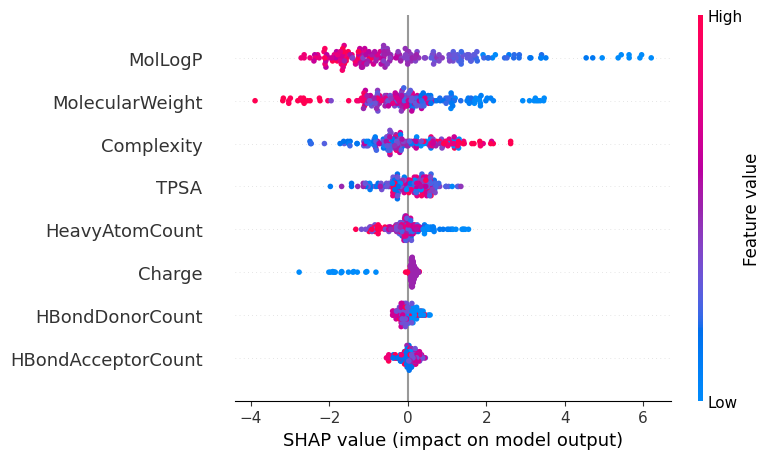

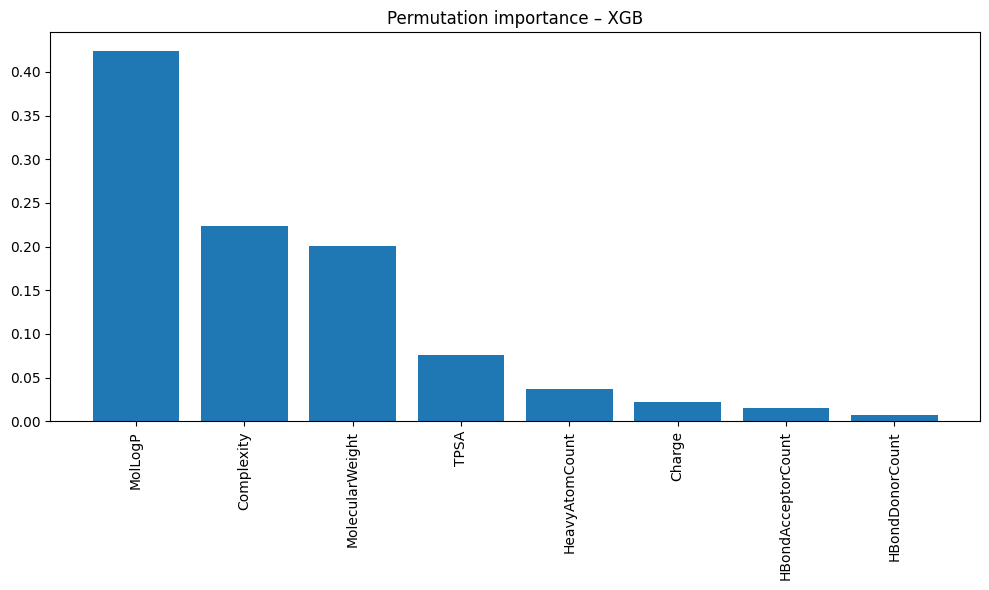

In [11]:
if has_shap:
    explainer = shap.TreeExplainer(best_xgb)
    shap_values = explainer.shap_values(X_test, check_additivity=False)
    shap.summary_plot(shap_values, X_test, show=False); plt.show()

from sklearn.inspection import permutation_importance
perm = permutation_importance(best_xgb, X_test, y_test, n_repeats=30, n_jobs=-1, random_state=42)
order = perm.importances_mean.argsort()[::-1]
plt.figure(figsize=(10,6))
plt.bar(range(len(order)), perm.importances_mean[order])
plt.xticks(range(len(order)), X_test.columns[order], rotation=90)
plt.title('Permutation importance – XGB'); plt.tight_layout(); plt.show()


## Save models

In [ ]:
ART = pathlib.Path('models'); ART.mkdir(exist_ok=True)
ridgeName = 'ridge{iso2vec}.pkl'.format(iso2vec = '_with_iso2vec' if USE_ISO2VEC else '_without-iso2vec')
joblib.dump(ridge, ART/ridgeName); 

rfName = 'rf{iso2vec}.pkl'.format(iso2vec = '_with_iso2vec' if USE_ISO2VEC else '_without-iso2vec')
joblib.dump(rf, ART/rfName)

xgbTunedName = 'xgb_tuned{iso2vec}.pkl'.format(iso2vec = '_with_iso2vec' if USE_ISO2VEC else '_without-iso2vec')
joblib.dump(best_xgb, ART/xgbTunedName)

hgbName = 'hgb{iso2vec}.pkl'.format(iso2vec = '_with_iso2vec' if USE_ISO2VEC else '_without-iso2vec')
joblib.dump(best_hgb, ART/hgbName)

lgbmName = 'lgbm{iso2vec}.pkl'.format(iso2vec = '_with_iso2vec' if USE_ISO2VEC else '_without-iso2vec')
if has_lgbm and 'LGBM' in results: joblib.dump(best_lgb, ART/lgbmName)

catName ='catboost{iso2vec}.pkl'.format(iso2vec = '_with_iso2vec' if USE_ISO2VEC else '_without-iso2vec')
if has_cat and 'CatBoost' in results: joblib.dump(cat, ART/'catboost.pkl')

stackingName = 'stacking{iso2vec}.pkl'.format(iso2vec = '_with_iso2vec' if USE_ISO2VEC else '_without-iso2vec')
joblib.dump(stack, ART/stackingName)


['models\\stacking.pkl']

## Generate Markdown report

In [ ]:
from pathlib import Path

sorted_items = sorted(results.items(), key=lambda kv: kv[1]["RMSE"])

lines = ['| Model | MAE | RMSE | R² |', '|---|---|---|---|']
for name, met in sorted_items:
    lines.append(f"| **{name}** | {met['MAE']:.3f} | {met['RMSE']:.3f} | {met['R2']:.3f} |")

report = f"""# ΔG Modeling Report (v2)

**Dataset file:** `{file.name}`  
**iso2vec used:** `{USE_ISO2VEC}`  

## Test-set metrics (sorted by lowest RMSE)

{chr(10).join(lines)}
"""
filename = "model_{iso2vec}report.md".format(iso2vec = 'with_iso2vec_' if USE_ISO2VEC else 'without-iso2vec_')

Path(filename).write_text(report, encoding="utf-8")
print(f"Report written to {filename}")

Report written to model_without-iso2vec_report.md
